In [1]:
import numpy as np
import scipy
import matplotlib.pylab as plt
import scipy.signal
from scipy import interpolate

Analytic Sedov Solution for $\gamma=5/3$
==

I've generated the dimensionless exact solution for the Sedov blast wave from a code on Frank Timmes website: https://cococubed.com/research_pages/sedov.shtml  This reads in the solution (stored in the data file `dataout.p`). The solution is scaled so the density, pressure, and velocity at the shock front is 1.  The radius of the shock front is also scaled to 1. I've generated interpolation functions, so you can get the exact solution for any value `x` by using `sedov_a_dens(x)`, `sedov_a_pres(x)`, and `sedov_a_vel(x)`.

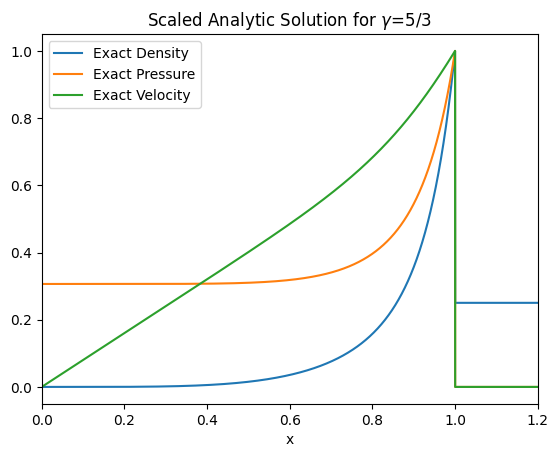

In [2]:
#Exact solution generated from python code at https://cococubed.com/research_pages/sedov.shtml, thanks!
sedov_position,sedov_dens,sedov_pres,sedov_vel = np.loadtxt("sedov.dat",unpack=True)

sedov_a_dens = interpolate.interp1d(sedov_position, sedov_dens)
sedov_a_pres = interpolate.interp1d(sedov_position, sedov_pres)
sedov_a_vel = interpolate.interp1d(sedov_position, sedov_vel)

plt.plot(sedov_position,sedov_dens,label="Exact Density")
plt.plot(sedov_position,sedov_pres,label="Exact Pressure")
plt.plot(sedov_position,sedov_vel,label="Exact Velocity")
plt.xlim(0,1.2)
plt.legend()
plt.title("Scaled Analytic Solution for $\gamma$=5/3")
plt.xlabel("x")
plt.show()

Analytic Sod Shock Tube Solution
==

I.ve generated the exact solution for the Sod shock tube at t=0.2 from a code on Frank Timmes website: https://cococubed.com/code_pages/exact_riemann.shtml (actually, this code will solve any Riemann problem (see below for more discussion in Riemann problems).  This reads in the solution (stored in the data file `sod_exact.dat`). I've generated interpolation functions, so you can get the exact solution for any value `x` by using `sod_a_dens(x)`, `sod_a_pres(x)`, and `sod_a_vel(x)`.

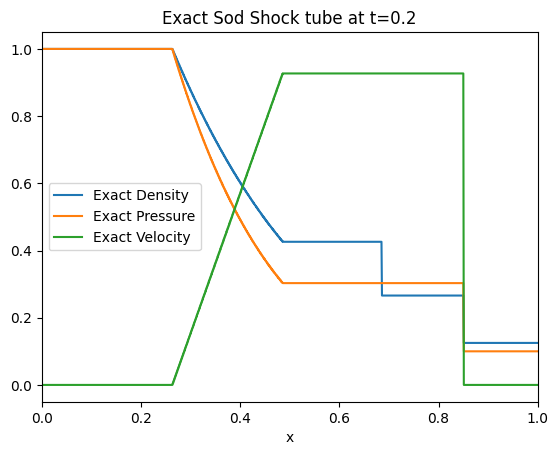

In [3]:
#Exact solution generated from fortran code at https://cococubed.com/code_pages/exact_riemann.shtml, thanks!
sod_position,sod_dens,sod_pres,sod_vel = np.loadtxt('sod_exact.dat',unpack=True,usecols=(1,2,3,4),skiprows=1)

sod_a_dens = interpolate.interp1d(sod_position, sod_dens)
sod_a_pres = interpolate.interp1d(sod_position, sod_pres)
sod_a_vel = interpolate.interp1d(sod_position, sod_vel)

plt.plot(sod_position,sod_dens,label="Exact Density")
plt.plot(sod_position,sod_pres,label="Exact Pressure")
plt.plot(sod_position,sod_vel,label="Exact Velocity")
plt.xlim(0,1.)
plt.legend()
plt.title("Exact Sod Shock tube at t=0.2")
plt.xlabel("x")
plt.show()

Initial Conditions
==

Throughout today's lab we will use several sets of initial conditions. Feel free to explore your own too. Here are functions that return the pressure, density, and velocity along with the cell center values of the x dimension for three setups.  These include a 1D Cartesian shock tube, a 1D Spherical Sedov blast wave, and a 1D Cartesian Gaussian pulse.

In [4]:
#define some initial data for the Sod's Shock tube
def initial_sod_shock(npoints=100):    
    dx = 1.0/npoints
    x = np.linspace(0,1,npoints,endpoint=False)+dx/2.0

    pres = np.zeros(npoints)
    dens = np.zeros(npoints)
    vel = np.zeros(npoints)
    gamma = 1.4
    
    #Left half of the domain
    pres[:int(npoints/2)] = 1.0
    dens[:int(npoints/2)] = 1.0
    vel[:int(npoints/2)] = 0.0
    
    #Right half of the domain
    pres[int(npoints/2):] = 0.1
    dens[int(npoints/2):] = 0.125
    vel[int(npoints/2):] = 0.0
    
    return x,pres,dens,vel,gamma

#define some initial data for the Sedov's blast wave
def initial_sedov(energy=1,amb_rho=1.,gamma=5.0/3.0,npoints=100):    
    dx = 1.0/npoints
    x = np.linspace(0,1,npoints,endpoint=False)+dx/2.0
    
    #Define the initial burst of energy, place within the first 5 zones
    nburst=5
    energy_density = energy/(4.0*np.pi*(nburst*dx)**3/3.0)
    pres = np.zeros(npoints)
    pres[0:nburst] = energy_density*(gamma-1)
    pres[nburst:] = 1e-4

    #constant ambitiant density
    dens = np.zeros(npoints)
    dens[:] = amb_rho
    
    #constant zero velocity
    vel = np.zeros(npoints)
    
    return x,pres,dens,vel,gamma

#define some initial data for a smooth spherical gaussian pulse
def initial_sph_gaussian_pulse(amb_rho=1.4,delta_rho=0.14,v=0.0,gamma=7.0/5.0,npoints=100):    
    dx = 1.0/npoints
    x = np.linspace(0,1,npoints,endpoint=False)+dx/2.0
    
    dens = np.zeros(npoints)
    pres = np.zeros(npoints)
    
    dens[:int(npoints/2)] = amb_rho + delta_rho*np.exp(-16.*x[:int(npoints/2)]**2)*np.cos(np.pi*x[:int(npoints/2)])**6
    dens[int(npoints/2):] = amb_rho
    pres = (dens/amb_rho)**gamma
    
    vel = np.zeros(npoints)
    vel[:] =  v
    
    return x,pres,dens,vel,gamma

Example Initial Conditions
==

Here are examples of generated initial conditions

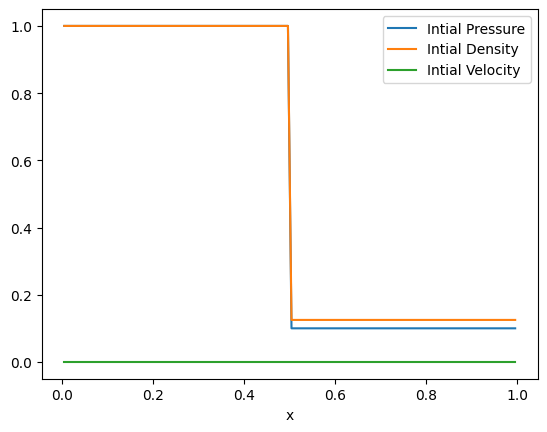

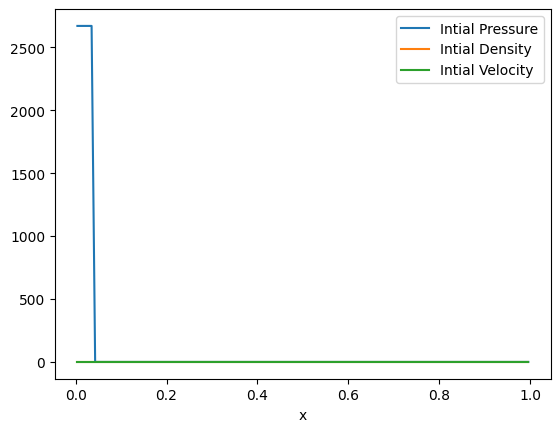

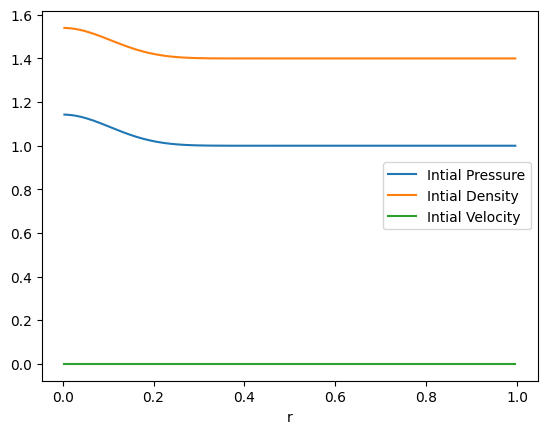

In [5]:
#generate and plot initial data, include labels, legends
npoints=128 #work with multiples of 2 to make the error estimate more easy
x,pres0,dens0,vel0,gamma0 = initial_sod_shock(npoints=npoints)
plt.plot(x,pres0,label="Intial Pressure")
plt.plot(x,dens0,label="Intial Density")
plt.plot(x,vel0,label="Intial Velocity")
plt.xlabel("x")
plt.legend()
plt.show()

#generate and plot initial data, include labels, legends
npoints=128 #work with multiples of 2 to make the error estimate more easy
x,pres0,dens0,vel0,gamma0 = initial_sedov(energy=1,amb_rho=1.,gamma=5.0/3.0,npoints=npoints)
plt.plot(x,pres0,label="Intial Pressure")
plt.plot(x,dens0,label="Intial Density")
plt.plot(x,vel0,label="Intial Velocity")
plt.xlabel("x")
plt.legend()
plt.show()

#generate and plot initial data, include labels, legends
npoints=128 #work with multiples of 2 to make the error estimate more easy
r,pres0,dens0,vel0,gamma0 = initial_sph_gaussian_pulse(amb_rho=1.4,delta_rho=0.14,v=0.00,gamma=7.0/5.0,npoints=npoints)
plt.plot(r,pres0,label="Intial Pressure")
plt.plot(r,dens0,label="Intial Density")
plt.plot(r,vel0,label="Intial Velocity")
plt.xlabel("r")
plt.legend()
plt.show()

The Hydro Solver
==

Here I provide you a hydro solver that is a combination of everything we did so far (and then some) in the numerical exercises in the class.  This is what you can use to perform the tasks of the exercise.  

Recall the equations we are solving (in 1D Cartesian; ignoring gravity):

$$\partial_t [\rho] + \partial_r [ \rho u ] = 0$$
$$\partial_t [\rho u] + \partial_r [\rho u^2 + P] = 0$$
$$\partial_t [E] + \partial_r [(E+P)u] = 0$$

Here, $E=\rho[u^2/2 + \epsilon]$ is the energy density (again, ignoring gravity) with $\epsilon$ being the specific internal energy from the equation of state. We often write these equations in the form of 

$$\partial_t [U] + \partial_r [F] = S$$

where $U=[\rho,\rho u, E]$, $F=[\rho u, \rho u^2 + P, (E+P)u]$, $S=[0,0,0]$.  The $U$ vector holds the 'conservative' variables (as opposed to the 'primative' variables of $\rho$, $P$, and $u$), the $F$ vector holds the fluxes of these variables, and the $S$ vector holds the sources of these variables.

The basic features are listed here:

1. This hydrodynamics solver is one dimensional, however it can do either Cartesian 1D or spherical 1D. These differ in the form of the diverance term and an extra source term in the momentum equation for the spherical case, In spherical symmetry, the above equation we solve is 
$$\partial_t [U] + \frac{1}{r^2}\partial_r [r^2 F] = S\,.$$
$U$ and $F$ are the same as above, but $S = [0,2P/r,0]$.

2. It can do a first order Runge-Kutta or a second order Runge-Kutta for the time evolution.  We learned about these Runge-Kutta solvers these in Lab #1. 
3. The inter-cell fluxes (needed for the evolution) are determined using an approximate Riemann solver (HLLE). We have not looked into the guts of Riemann solvers before and rather just used basic ones, i.e. upwinding for the advection equation.  However, the Euler equations are non-linear and therefore more care is needed to determine the fluxes.  Recall (from lab #2) a Riemann solver takes an estimate of the flux on the left side of the interface and the right side of the interface and computes the intercell flux.  We determine the left and right fluxes by "reconstructing" the state variables ($\rho$, $P$, and $u$) to the interface. We do this using a second order TVD (total variation diminishing), limited (with the minmod limiter) scheme.
4. Since we evolve the 'conservative' variables, i.e. $U$ and not $\rho$, $P$, and $u$ directly (well actually we do evolve $\rho$ directly), after each runge-kutta evolution step we need to 'recover' the 'primatives', sometimes called the `con2prim`.

In [6]:
#minmod limiter for TVD
def minmod(a,b):
    if a*b>0:
        if np.abs(a)<np.abs(b):
            return a
        else:
            return b
    else:
        return 0

#given a type of geometry, 'spherical' or 'Cartesian', this routine calculates,
#given a grid, the face areas and vol terms used in the flux calculation
def do_geometry(x,ng,geometry):
    
    npoints = len(x)
    Deltax = x[1]-x[0]
    Ap = np.zeros(npoints+2*ng)
    Am = np.zeros(npoints+2*ng)
    vol = np.zeros(npoints+2*ng)

    if geometry=='spherical':
        for i in range(ng,npoints+ng):
            rp = x[i-ng] + Deltax / 2.0
            rm = x[i-ng] - Deltax / 2.0
            Ap[i] = 4.0*np.pi*rp**2
            Am[i] = 4.0*np.pi*rm**2
            vol[i] = 4.0*np.pi*x[i-ng]**2*Deltax
    elif geometry=='Cartesian':
        Ap[:] = 1.0
        Am[:] = 1.0
        vol[:] = Deltax
    else:
        print("Geometry not defined")
    
    return Ap,Am,vol

#unlike the advection equation we had before, now the timestep is
#limited by the sound crossing time of the computational cell.
#Therefore, given a set of state variables in 'state' this routine
#determines the fastest speed, which in turn sets the timestep 
def get_fastestspeed(state):
    cs2 = state['gamma']*state['pres']/state['dens']
    fastestspeed = np.max(np.sqrt(cs2)+np.abs(state['vel']))
    return fastestspeed

#this fills in the boundary condtions
def do_boundaries(state,ng,vars,boundary):
    if boundary=='reflect':
        for var in vars:
            #for reflecting v at boundary, for sod, should be v=0, so doesn't matter
            sign = 1
            if var=='vel' or var=='mom': sign = -1
            state[var][0] = state[var][ng+1]*sign
            state[var][1] = state[var][ng]*sign

            state[var][-2] = state[var][-ng-1]*sign
            state[var][-1] = state[var][-ng-2]*sign
    elif boundary=='periodic':
        for var in vars:
            #for reflecting v at boundary, for sod, should be v=0, so doesn't matter
            state[var][0] = state[var][-ng-2]
            state[var][1] = state[var][-ng-1]

            state[var][-2] = state[var][ng]
            state[var][-1] = state[var][ng+1]
    else:
        print("Boundary not defined!")
    return state
    

#this is the Riemann solver, one of the two big functions for the hydro solver.
#It takes the current state and from it
#1. reconstructs the variables to the two sides of the interface
#2. determines the fluxes (see above equation) on the two sides of the interface
#3. uses the HLLE riemann solver to estimate the flux _through_ the interface
#4. returns the flux to the hydro solver
def get_fluxes_given_state(x,ng,staten):
    npoints = len(staten['dens'])
    
    gamma = staten['gamma']
    
    #reconstruct to interface via TVD. Note, these are the +(p) and -(m) sides of zone i, not of the interface
    statenp = {'pres':np.zeros(npoints),'dens':np.zeros(npoints),'vel':np.zeros(npoints)}
    statenm = {'pres':np.zeros(npoints),'dens':np.zeros(npoints),'vel':np.zeros(npoints)}
    
    vars = ['pres','dens','vel','mom','ener']
    cvars = ['dens','mom','ener']
    pvars = ['pres','dens','vel']
    
    for var in pvars:
        #don't need these, just prevents warnings
        statenp[var][0] = staten[var][0]
        statenm[var][0] = staten[var][0]
        for i in range(ng-1,npoints-ng+1):
            statenp[var][i] = staten[var][i] + 1.0/2.0*minmod(staten[var][i]-staten[var][i-1],staten[var][i+1]-staten[var][i])
            statenm[var][i] = staten[var][i] - 1.0/2.0*minmod(staten[var][i]-staten[var][i-1],staten[var][i+1]-staten[var][i])
        #don't need these, just prevents warnings
        statenp[var][-1] = staten[var][-1]
        statenm[var][-1] = staten[var][-1]
    
    statenp['cs2'] = gamma*statenp['pres']/statenp['dens']
    statenm['cs2'] = gamma*statenm['pres']/statenm['dens']
    
    statenp['mom'] = statenp['dens']*statenp['vel']
    statenm['mom'] = statenm['dens']*statenm['vel']
    
    statenp['ener'] = statenp['dens']*0.5*statenp['vel']**2 + statenp['pres']/(gamma-1.)
    statenm['ener'] = statenm['dens']*0.5*statenm['vel']**2 + statenm['pres']/(gamma-1.)

    #riemann problem is interface_flux(i) = R(statenp(i),statenm(i+1))
    #HLLE riemann solver is 
    #interface_flux[var] = [FL[var]*lambdamax - FR[var]*lambdamin - 
    #                        (lambdamax*lambdamin)*(stateR[var]-stateL[var])]/(lambdamax-lambdamin)
    
    fluxesp = {}
    fluxesm = {}
    #first get fluxes at interfaces
    fluxesp['dens'] = statenp['dens']*statenp['vel']
    fluxesm['dens'] = statenm['dens']*statenm['vel']
    
    fluxesp['mom'] = statenp['dens']*statenp['vel']**2+statenp['pres']
    fluxesm['mom'] = statenm['dens']*statenm['vel']**2+statenm['pres']
    
    fluxesp['ener'] = (0.5*statenp['vel']**2 + statenp['cs2']/(gamma-1.))*statenp['vel']*statenp['dens']
    fluxesm['ener'] = (0.5*statenm['vel']**2 + statenm['cs2']/(gamma-1.))*statenm['vel']*statenm['dens']
    
    #next get lambdas at interface
    lambdas = np.zeros(npoints*7).reshape(npoints,7)
    lambdas[ng-1:npoints-ng+1,0] = statenp['vel'][ng-1:npoints-ng+1]
    lambdas[ng-1:npoints-ng+1,1] = statenp['vel'][ng-1:npoints-ng+1]+np.sqrt(statenp['cs2'][ng-1:npoints-ng+1])
    lambdas[ng-1:npoints-ng+1,2] = statenp['vel'][ng-1:npoints-ng+1]-np.sqrt(statenp['cs2'][ng-1:npoints-ng+1])
    lambdas[ng-1:npoints-ng+1,3] = statenm['vel'][ng:npoints-ng+2]
    lambdas[ng-1:npoints-ng+1,4] = statenm['vel'][ng:npoints-ng+2]+np.sqrt(statenm['cs2'][ng:npoints-ng+2])
    lambdas[ng-1:npoints-ng+1,5] = statenm['vel'][ng:npoints-ng+2]-np.sqrt(statenm['cs2'][ng:npoints-ng+2])
    lambdas[ng-1:npoints-ng+1,6] = 0.0

    lambdamax = np.max(lambdas,axis=1)
    lambdamin = np.min(lambdas,axis=1)
    
    
    interface_fluxes = {}
    for var in cvars:
        interface_fluxes[var] = np.zeros(npoints)
        for i in range(ng-1,npoints-ng+1):
            interface_fluxes[var][i] = ((
                        fluxesp[var][i]*lambdamax[i] - 
                        fluxesm[var][i+1]*lambdamin[i] + 
                        lambdamin[i]*lambdamax[i]*(statenm[var][i+1]-statenp[var][i]))/
                        (lambdamax[i]-lambdamin[i]))
    
    return interface_fluxes

#this is the core routine that evolve the state forward in time one step.
def evolve_one(x,staten,Deltat,geometry,boundary,order):
    
    if order==1:
        coeffs = [1.0,0]
    elif order==2:
        coeffs = [0.5,1.0]
        
    gamma = staten['gamma']
    
    npoints = len(staten['dens'])
    
    statenp1 = {'dens':np.zeros(npoints),'pres':np.zeros(npoints),'vel':np.zeros(npoints)}
    Deltax = x[1]-x[0]
        
    #first get the conservative state
    staten['mom'] = staten['dens']*staten['vel']
    staten['ener'] = staten['dens']*0.5*staten['vel']**2 + staten['pres']/(gamma-1.0)
    
    #guard cells to make equations simpler, reflect
    ng=2
    vars = ['pres','dens','vel','mom','ener']
    cvars = ['dens','mom','ener']

    scratch_staten = {'gamma':gamma}
    scratch_statenphalf = {'gamma':gamma}
    scratch_statenp1 = {'gamma':gamma}
    for var in vars:
        scratch_staten[var] = np.zeros(npoints+2*ng)
        scratch_statenphalf[var] = np.zeros(npoints+2*ng)
        scratch_statenp1[var] = np.zeros(npoints+2*ng)

        scratch_staten[var][ng:-ng] = staten[var][:]
    
    #set boundary conditions
    scratch_staten = do_boundaries(scratch_staten,ng,vars,boundary)

    #riemann solver
    fluxes = get_fluxes_given_state(x,ng,scratch_staten)
    Ap,Am,vol = do_geometry(x,ng,geometry)
    
    #geometric sources
    sources = {}
    sources['dens'] = np.zeros(npoints+2*ng)
    sources['ener'] = np.zeros(npoints+2*ng)
    sources['mom'] = np.zeros(npoints+2*ng)
    if geometry=='spherical':
        sources['mom'][ng:npoints+ng] = 2.0*scratch_staten['pres'][ng:npoints+ng]/x[:]
        
    #first stage
    #loop over zones and evolve to n+1/2
    rk_dt = Deltat*coeffs[0]
    for var in cvars:
        for i in range(ng,npoints+ng):
            scratch_statenphalf[var][i] = scratch_staten[var][i] - rk_dt*(Ap[i]*fluxes[var][i]-Am[i]*fluxes[var][i-1])/vol[i] + rk_dt*sources[var][i]
        
    #con2prim; recover vel and press from dens,mom,ener
    scratch_statenphalf['vel'][ng:npoints+ng] = scratch_statenphalf['mom'][ng:npoints+ng]/scratch_statenphalf['dens'][ng:npoints+ng]
    scratch_statenphalf['pres'] = (scratch_statenphalf['ener']-
                                    0.5*scratch_statenphalf['dens']*scratch_statenphalf['vel']**2)*(gamma-1.)
    
    if order==1:
        #we're done, no need for second step
        statenp1['x'] = x
        statenp1['dens'] =  scratch_statenphalf['dens'][ng:npoints+ng]
        statenp1['vel'] =  scratch_statenphalf['vel'][ng:npoints+ng]
        statenp1['pres'] =  scratch_statenphalf['pres'][ng:npoints+ng]  
        statenp1['gamma'] = gamma
        return statenp1
    
    #second stage
    #reset boundaries as variables have change
    scratch_statenphalf = do_boundaries(scratch_statenphalf,ng,vars,boundary)

    #riemann solver
    fluxes = get_fluxes_given_state(x,ng,scratch_statenphalf)

    #geometric sources
    if geometry=='spherical':
        sources['mom'][ng:npoints+ng] = 2.0*scratch_statenphalf['pres'][ng:npoints+ng]/x[:]

    rk_dt = Deltat*coeffs[1]   
    #evolve
    for var in cvars:
        for i in range(ng,npoints+ng):
            scratch_statenp1[var][i] = scratch_staten[var][i] - rk_dt*(Ap[i]*fluxes[var][i]-Am[i]*fluxes[var][i-1])/vol[i] + rk_dt*sources[var][i]

    #con2prim; recover vel and press from dens,mom,ener
    scratch_statenp1['vel'][ng:npoints+ng] = scratch_statenp1['mom'][ng:npoints+ng]/scratch_statenp1['dens'][ng:npoints+ng]
    scratch_statenp1['pres'] = (scratch_statenp1['ener']-
                                    0.5*scratch_statenp1['dens']*scratch_statenp1['vel']**2)*(gamma-1.)
                        
    statenp1['x'] = x
    statenp1['dens'] =  scratch_statenp1['dens'][ng:npoints+ng]
    statenp1['vel'] =  scratch_statenp1['vel'][ng:npoints+ng]
    statenp1['pres'] =  scratch_statenp1['pres'][ng:npoints+ng]
    statenp1['gamma'] = gamma
    
    return statenp1

Example: Gaussian Pulse
==


In [ ]:
def evolve_SGP(npoints,C,tend,order):

    x,pres0,dens0,vel0,gamma0 = initial_sph_gaussian_pulse(amb_rho=1.4,delta_rho=0.14,v=0.0,gamma=1.4,npoints=npoints)

    Deltax = x[1]-x[0]

    state0 = {}
    state0['dens'] = dens0
    state0['pres'] = pres0
    state0['vel'] = vel0
    state0['gamma'] = gamma0
    state0['x']=x
    staten = state0
    t = 0
    states = {}
    times = {}
    
    count=0
    outputcount = 0
    outputeveryn = 10

    while t<tend-1e-10:

        if count%outputeveryn==0:
            times[outputcount] = t
            states[outputcount] = staten
            outputcount += 1

        #set time step, note, this doesn't use the sound speed, however we are modelling
        #this off of McCorquodale \& Colella, \emph{CAMCOS} 6 1 (2011), 
        #this uses \Delta t = 0.192\Delta x
        Deltat = C*Deltax
        if t+Deltat>tend: Deltat = tend-t

        #evolve the density
        statenp1 = evolve_one(x,staten,Deltat,geometry='spherical',boundary='reflect',order=order)

        #set n state to the n+1 state and go to the next time step
        staten=statenp1
        t = t+Deltat
        count += 1

    times[outputcount] = t
    states[outputcount] = staten
    outputcount += 1
    
    return times,states

In [ ]:
#A sample evolution of the spherical Gaussian pulse
C=0.192
tend=0.24
order=2

npoints=100
GPtimes, GPstates = evolve_SGP(npoints,C,tend,order) 

In [ ]:
#and plotting the density several times between t=0 and t=0.24
for state in GPstates:
    plt.plot(GPstates[state]['x'],GPstates[state]['dens'],label="t={:.3f}".format(GPtimes[state]))

plt.legend(frameon=False,loc="right")
plt.xlabel('x')
plt.show()

In [ ]:
#A basic setup up determining the error between evolutions with different setups.
#The exercise ask you to explore varying C (an example is done here) for different
#temporal orders and also varying the resolution for fixed C. If C is varied and
#the spacing is helf fixed the self-convergence error is easy to determine (it is just the difference).
#If you vary the spatial size, use a factor of 2, then compare the average density
#across two finer resolution zones to the one coarse zone
baseCFL =0.192
Cs=[baseCFL,baseCFL/2.,baseCFL/4.,baseCFL/8.]
tend=0.24
order=1
endstate_order1 = {}

for i in range(len(Cs)):
    C=Cs[i]
    npoint = 100
    times,states = evolve_SGP(npoint,C,tend,order=order)
    state = states[len(states)-1]
    endstate_order1[i] = state


#for each pair, coarse the HR to the LR, compute error for density
L2norms_order1 = []
for pair in [(1,0),(2,1),(3,2)]:
    densHR = endstate_order1[pair[0]]['dens']
    densLR = endstate_order1[pair[1]]['dens']
    L2norms_order1.append(np.sqrt(1/len(densLR)* sum((densHR-densLR)**2)))


order=2
endstate_order2 = {}

for i in range(len(Cs)):
    C=Cs[i]
    npoint = 100
    times,states = evolve_SGP(npoint,C,tend,order=order)
    state = states[len(states)-1]
    endstate_order2[i] = state

#for each pair, coarse the HR to the LR, compute error for density
L2norms_order2 = []
for pair in [(1,0),(2,1),(3,2)]:
    densHR = endstate_order2[pair[0]]['dens']
    densLR = endstate_order2[pair[1]]['dens']
    L2norms_order2.append(np.sqrt(1/len(densLR)* sum((densHR-densLR)**2)))
    


In [ ]:
res = [1,2,4]
plt.loglog(res,L2norms_order1,label='order 1 error')
plt.loglog(res,L2norms_order2,label='order 2 error')
plt.loglog(res,[L2norms_order1[0]/2**i for i in range(3)],'C0--',label='first order')
plt.loglog(res,[L2norms_order1[0]/2**(2.*i) for i in range(3)],'C0:',label='second order')

plt.loglog(res,[L2norms_order2[0]/2**i for i in range(3)],'C1--',label='first order')
plt.loglog(res,[L2norms_order2[0]/2**(2.*i) for i in range(3)],'C1:',label='second order')
plt.legend()
plt.show()

Example: Sod Shock Tube
==

First some talk about Riemann solvers
--

Something that we didn't really cover in the class, or in the numerical sessions is the Riemann problem.  Given a set of piecewise constant initial conditions at $t=0$ (i.e. $\rho=\rho_0$, $P=P_0$, $u=u_0$ for $x<0.5$ and $\rho=\rho_1$, $P=P_1$, $u=u_1$ for $x>0.5$).  The solution to this so-called Riemann problem (as given by the Euler equations) is the value of $\rho$, $P$, and $u$ for all $x$ and $t>0$.  The Riemann problem is solvable. 

We have touch on a related idea before, in lab #2. Have a look at the initial conditions for the shock tube up above in this lab. On the left of the domain ($x<0.5$) we have one constant state, on the right ($x>0.5$) we have another constant state. This is just like the setup we have at every interface in our computational domain, a state on the left of the interface, a state on the right, and a discontinuity in between. Since the Riemann problem is solvable, in principle we can determine the flux of any variable through the $x=0.5$ interface, which is exactly what we need in numerical hydrodynamics. This is why in lab #2 we referred to the determination of the flux as a Riemann problem. Solving the full Riemann problem, while possible, is quite computationally expensive (especially if you need to solve it at every interface for every time step). Therefore there are many approximate Riemann solvers that attempt to give a good enough answer with minimal effort.

In essence, a shock tube is just one big Riemann problem. Therefore, from the exact solution to the initial Riemann problem we know what the evolution everywhere should be.  This makes shock tubes great test problems for numerical hydrodynamics.  Shock tubes are very important for testing various aspects of numerical scheme such as the approximate Riemann solver and the reconstruction methods. 

Sod's Shock tube (Sod, Journal of Computational Physics 27, 1, 1978) is a classic shock tube, and the one we will use today.

In [ ]:
def evolve_SST(npoints,C,tend,order):

    x,pres0,dens0,vel0,gamma0 = initial_sod_shock(npoints=npoints)

    Deltax = x[1]-x[0]

    state0 = {}
    state0['dens'] = dens0
    state0['pres'] = pres0
    state0['vel'] = vel0
    state0['gamma'] = gamma0
    state0['x']=x
    staten = state0
    t = 0
    states = {}
    times = {}
    
    count=0
    outputcount = 0
    outputeveryn = 10

    while t<tend-1e-10:

        if count%outputeveryn==0:
            times[outputcount] = t
            states[outputcount] = staten
            outputcount += 1

        #set time step
        fastestspeed = get_fastestspeed(staten)
        Deltat = C*Deltax/np.abs(fastestspeed)
        if t+Deltat>tend: Deltat = tend-t

        #evolve the density
        statenp1 = evolve_one(x,staten,Deltat,geometry='Cartesian',boundary='reflect',order=order)

        #set n state to the n+1 state and go to the next time step
        staten=statenp1
        t = t+Deltat
        count += 1

    times[outputcount] = t
    states[outputcount] = staten
    outputcount += 1
    
    return times,states

In [ ]:
npoints=[50,100,200,400,800]
C=0.5
tend=0.2
SSTendstate_order1 = {}

endstate_order1 = {}
for npoint in npoints:
    SSTtimes,SSTstates = evolve_SST(npoint,C,tend,order=1)
    state = SSTstates[len(SSTstates)-1]
    SSTendstate_order1[npoint] = state

In [ ]:
npoints=[50,100,200,400,800]
index=0
for npoint in npoints:
    plt.plot(SSTendstate_order1[npoint]['x'],SSTendstate_order1[npoint]['dens'],'C'+str(index),label="Dens"+str(npoint))
    index+=1
plt.plot(SSTendstate_order1[400]['x'],sod_a_dens(SSTendstate_order1[400]['x']),'k--',label="Dens0",alpha=0.7)
plt.legend(frameon=False)
plt.show()
index=0
for npoint in npoints:
    plt.plot(SSTendstate_order1[npoint]['x'],SSTendstate_order1[npoint]['pres'],'C'+str(index),label="Pres"+str(npoint))
    index+=1
plt.plot(SSTendstate_order1[400]['x'],sod_a_pres(SSTendstate_order1[400]['x']),'k--',label="Pres0",alpha=0.7)
plt.legend(frameon=False)
plt.show()
index=0
for npoint in npoints:
    plt.plot(SSTendstate_order1[npoint]['x'],SSTendstate_order1[npoint]['vel'],'C'+str(index),label="Vel"+str(npoint))
    index+=1
plt.plot(SSTendstate_order1[400]['x'],sod_a_vel(SSTendstate_order1[400]['x']),'k--',label="Vel0",alpha=0.7)
plt.legend(frameon=False)
plt.show()


Example: Sedov Blast Wave
==

In [7]:
def evolve_SBW(energy,amb_rho,gamma0,npoints,C,tend,order):

    x,pres0,dens0,vel0,gamma0 = initial_sedov(energy=energy,amb_rho=amb_rho,gamma=gamma0,npoints=npoints)

    Deltax = x[1]-x[0]

    state0 = {}
    state0['dens'] = dens0
    state0['pres'] = pres0
    state0['vel'] = vel0
    state0['gamma'] = gamma0
    state0['x']=x
    staten = state0
    t = 0
    states = {}
    times = {}
    
    count=0
    outputcount = 0
    outputeveryn = 10

    while t<tend-1e-10:

        if count%outputeveryn==0:
            times[outputcount] = t
            states[outputcount] = staten
            outputcount += 1

        #set time step
        fastestspeed = get_fastestspeed(staten)
        Deltat = C*Deltax/np.abs(fastestspeed)
        if t+Deltat>tend: Deltat = tend-t

        #evolve the density
        statenp1 = evolve_one(x,staten,Deltat,geometry='spherical',boundary='reflect',order=order)

        #set n state to the n+1 state and go to the next time step
        staten=statenp1
        t = t+Deltat
        count += 1

    times[outputcount] = t
    states[outputcount] = staten
    outputcount += 1
    
    return times,states

In [8]:
C=0.5
tend=0.17
order=2
energy=10
amb_rho=1
gamma0=5.0/3.0

npoints=50
SBWtimes, SBWstates = evolve_SBW(energy,amb_rho,gamma0,npoints,C,tend,order)

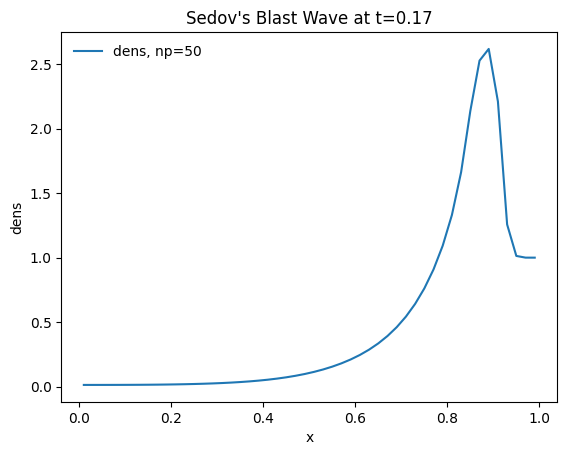

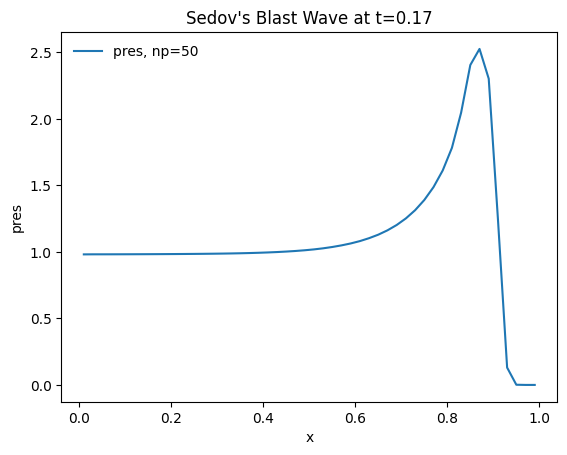

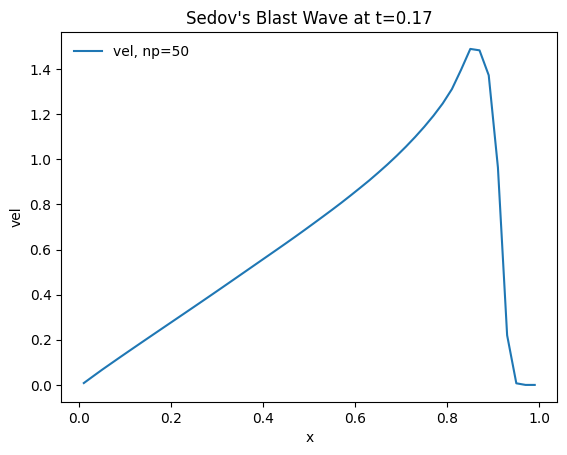

In [9]:
for var in ['dens','pres','vel']:
    state = len(SBWstates)-1
    plt.plot(SBWstates[state]['x'],SBWstates[state][var],label=var+", np=50")

    plt.title("Sedov's Blast Wave at t="+str(SBWtimes[state]))
    
    #Exact:
    alpha = 1.1502203505 
    time = 0.17
    analytic_shock_radius = alpha*(energy/amb_rho)**0.2*time**0.4
    rhoshock = (gamma0+1.0)/(gamma0-1.0)
    
    
    
    plt.plot(SBWstates[state]['x'],sedov_a_dens(,label=var+", np=50")

    
    plt.legend(loc='upper left',frameon=False)
    plt.xlabel('x')
    plt.ylabel(var)
    plt.show()